In [2]:
# 기본적인 Naive RAG -> 조건부엣지 검사 -> 웹 검색 -> 쿼리 재작성
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

In [13]:
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import PromptTemplate

# PDF 문서를 기반으로 검색 도구 생성
retriever_tool = create_retriever_tool(
    pdf_retriever,
    "pdf_retriever",        # LLM이 참고하는 제목
    # LLM이 참고하는 설명
    "Search and return information about SPRI AI Brief PDF file. It contains useful information on recent AI trends. The document is published on Dec 2023.",
    # 작성양식
    document_prompt=PromptTemplate.from_template(
        "<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"
    ),
)

# 생성된 검색 도구를 도구 리스트에 추가하여 에이전트에서 사용 가능하도록 설정
tools = [retriever_tool]

print(retriever_tool.invoke("삼성전자가 개발한 생성형 AI"))

<document><context>▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10
▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11
▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12</context><metadata><source>SPRI_AI_Brief_2023년12월호_F.pdf</source><page>1</page></metadata></document>

<document><context>SPRi AI Brief |
2023-12월호
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
KEY Contents
n 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성
AI 모델 ‘삼성 가우스’를 공개
n 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한
삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유
£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원</context><metadata><source>SPRI_AI_Brief_2023년12월호_F.pdf</source><page>12</page></metadata></document>

<document><context>어시스턴트를 적용한 구글 픽셀(Pixel)과 경쟁할 것으로 예상
☞ 출처 : 삼성전자, ‘삼성 AI 포럼’서 자체 개발 생성형 AI ‘삼성 가우스’ 공개, 2023.11.08.
삼성전자, ‘삼성 개발자 콘퍼런스 코리아 2023’ 개최, 2023.11.14.
TechRepublic, Samsung Gauss: Samsung Resear

In [5]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
from typing import Literal
from langchain import hub
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition

MODEL_NAME = 'gpt-5-nano'

class grade(BaseModel):
    binary_score: str = Field(
        description="Response 'yes' if the document is relevant to the question or 'no' if it is not."
    )

# 문서 점수 노드
def grade_documents(state) -> Literal["generate", "rewrite"]:
    model = ChatOpenAI(temperature=0, model=MODEL_NAME, streaming=True)
    llm_with_tool = model.with_structured_output(grade)
    prompt = PromptTemplate(template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""", input_variables = ["context", "question"])
    
    # llm + tool 체인
    chain = prompt | llm_with_tool

    # 현재 상태에서 메시지
    messages = state["messages"]

    # 가장 마지막 메시지
    last_message = messages[-1]

    # 원래 질문
    question = messages[0].content

    # 검색된 문서
    retrieved_docs = last_message.content

    # 관련성 평가
    scored_result = chain.invoke({"question":question, "context":retrieved_docs})

    # 관련성 여부
    score = scored_result.binary_score

    if score == "yes":
        print("==== [DECISION: DOCS RELEVANT] ====")
        return "generate"
    else:
        print("==== [DECISION: DOCS NOT RELEVANT] ====")
        print(score)
        return "rewrite"
    
# 에이전트 노드
def agent(state):
    # 현재 상태의 메시지 추출
    messages = state["messages"]

    model = ChatOpenAI(temperature=0, streaming=True, model=MODEL_NAME)

    model = model.bind_tools(tools)

    # 에이전트 응답 생성
    response = model.invoke(messages)

    return {"messages":[response]}

def rewrite(state):
    print("==== [QUERY REWRITE] ====")
    # 현재 상태의 메시지
    messages = state["messages"]

    # 원래 질문
    question = messages[0].content

    # 질문 개선을 위한 프롬프트
    msg = [
        HumanMessage(
            content=f""" \n
Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # LLM 모델로 질문을 개선
    model = ChatOpenAI(temperature=0, model=MODEL_NAME, streaming=True)
    response = model.invoke(msg)

    # 재작성된 질문을 반환
    return {"messages": [response]}

def generate(state):
    # 현재 상태의 메시지
    messages = state["messages"]

    # 원래 질문
    question = messages[0].content

    # 가장 마지막 메시지
    docs = messages[-1].content

    prompt = hub.pull("teddynote/rag-prompt")

    # LLM 모델 초기화
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0, streaming=True)

    # RAG 체인
    rag_chain = prompt | llm | StrOutputParser()

    # 답변 생성
    response = rag_chain.invoke({"context":docs, "question":question})
    return {"messages":[response]}


In [14]:
prompt = hub.pull("teddynote/rag-prompt")
prompt

PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'teddynote', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': 'f42521f58f89165b1784695ac09ff4fb7b750dd7227b0aaf952521e91f629e88'}, template="You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. \nYour primary mission is to answer questions based on provided context or chat history.\nEnsure your response is concise and directly addresses the question without any additional narration.\n\n###\n\nYour final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.\n\n# Steps\n\n1. Carefully read and understand the context provided.\n2. Identify the key information related to the question within the context.\n3. Formulate a concise answer based on the relevant information.\n4. Ensure your final answer dir

In [15]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# 상태그래프 생성
workflow = StateGraph(AgentState)

# 상태그래프에 노드 추가
workflow.add_node("agent", agent)       # 에이전트 노드
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)     # 검색 노드
workflow.add_node("rewrite", rewrite)       # 질문 변경 노드
workflow.add_node("generate", generate)     # 관련 문서 확인 후 응답 생성 노드

# 상태그래프의 노드를 엣지로 연결
workflow.add_edge(START, "agent")       # START -> agent
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",        # 도구 필요하면 retrieve 노드로
        END: END                # 도구 필요없으면 바로 END
    }
)
# workflow.add_edge("agent", "retrieve")
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")


# 상태그래프 컴파일
graph = workflow.compile()

# 상태그래프 시각화(디버깅)

# 상태그래프 실행

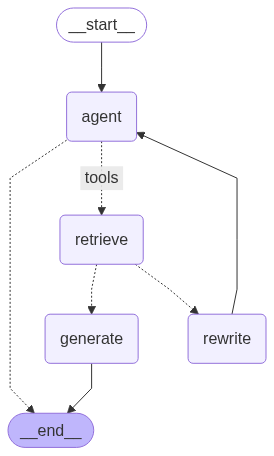

In [16]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정 (재귀 최대 횟수 / thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

inputs = {
    "messages": [
        ("user", "삼성전자가 개발한 생성형 AI 의 이름은? 문서에서 검색")
    ]
}

invoke_graph(graph, inputs, config)


🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  pdf_retriever (call_WjzGtjDOF8oF6WsD3KXl0dxq)
 Call ID: call_WjzGtjDOF8oF6WsD3KXl0dxq
  Args:
    query: Samsung
==== [DECISION: DOCS RELEVANT] ====

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: pdf_retriever

<document><context>어시스턴트를 적용한 구글 픽셀(Pixel)과 경쟁할 것으로 예상
☞ 출처 : 삼성전자, ‘삼성 AI 포럼’서 자체 개발 생성형 AI ‘삼성 가우스’ 공개, 2023.11.08.
삼성전자, ‘삼성 개발자 콘퍼런스 코리아 2023’ 개최, 2023.11.14.
TechRepublic, Samsung Gauss: Samsung Research Reveals Generative AI, 2023.11.08.
10</context><metadata><source>SPRI_AI_Brief_2023년12월호_F.pdf</source><page>12</page></metadata></document>

<document><context>처리를 지원
∙ 코드 모델 기반의 AI 코딩 어시스턴트 ‘코드아이(code.i)’는 대화형 인터페이스로 서비스를 제공하며
사내 소프트웨어 개발에 최적화
∙ 이미지 모델은 창의적인 이미지를 생성하고 기존 이미지를 원하는 대로 바꿀 수 있도록 지원하며
저해상도 이

In [ ]:
from langchain_core.messages import BaseMessage

last_text = ""

for _, chunk in graph.stream(inputs, config=config, stream_mode="updates", subgraphs=True):
    for _, value in chunk.items():
        if "messages" in value:
            for msg in value["messages"]:
                # BaseMessage 계열이면 content, 아니면 str()로 출력
                if isinstance(msg, BaseMessage):
                    text = msg.content
                else:
                    text = str(msg)
                if text:
                    print(text, end="", flush=True)
                    last_text = text  # 마지막 텍스트 갱신


==== [DECISION: DOCS RELEVANT] ====
<document><context>▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10
▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11
▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12</context><metadata><source>SPRI_AI_Brief_2023년12월호_F.pdf</source><page>1</page></metadata></document>

<document><context>SPRi AI Brief |
2023-12월호
삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개
KEY Contents
n 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성
AI 모델 ‘삼성 가우스’를 공개
n 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한
삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유
£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원</context><metadata><source>SPRI_AI_Brief_2023년12월호_F.pdf</source><page>12</page></metadata></document>

<document><context>£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원
n 삼성전자가 2023년 11월 8일 열린 ‘삼성 AI 포럼 2023’ 행사에서 자체 개발한 생성 AI 모델
‘삼성 가우스’를 최초 공개
∙ 정규분포 이론을 정립한 천재 수학자 가우스(Gau

In [22]:
print(last_text)

삼성 가우스

**Source**
- SPRI_AI_Brief_2023년12월호_F.pdf, p.12
